In [1]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import label
from skimage.measure import regionprops
from skimage.transform import rotate

from src.fish import find_fish_props
from src.models import BoundingBox
from src.models import InputImage
from src.utils import normalize_0_255
from src.well import find_well_props

# Functions

In [2]:
def plot_images(images, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, hist=False, nums=True):
    if count is not None:
        images = images[0:count]

    l = len(images)

    if l == 0:
        return

    if cols is None:
        cols = 4

    rows = int(l / cols)
    if cols > l > 1: cols = l
    if l % cols != 0 or rows == 0:
        rows += 1

    fig, ax = plt.subplots(rows, cols, figsize=fig)
    ax = ax.ravel()

    for i, img in enumerate(images):
        if i >= l: return

        if nums: ax[i].set_title(f'#{i}')

        if not hist:
            ax[i].imshow(img, cmap)
            if not ticks:  # turn off ticks
                ax[i].get_xaxis().set_visible(False)
                ax[i].get_yaxis().set_visible(False)
        else:
            ax[i].hist(img.ravel(), bins=256)
    fig.suptitle(title, fontsize=56)
    plt.tight_layout()


def plot_fishes(fishes, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, nums=False):
    images = list(map(lambda x: x.processed, fishes))  # Change this!
    plot_images(images, cols, count, fig, ticks, cmap, title, nums)

In [3]:
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src\\images\\temp')
fish_names = os.listdir()
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src')

fishes = []
successful_fishes = []
bad_names = []
for name in fish_names[::]:
    print(name)
    fishes.append(InputImage(name))
for i, fish in enumerate(fishes):
    print(f'Fish #{i}')
    fish.processed = normalize_0_255(fish.processed)
    fish = find_well_props(fish)
    fish = find_fish_props(fish)
    if fish.success:
        successful_fishes.append(fish)
    else:
        bad_names.append(fish)

fishes = successful_fishes.copy()

zf1.JPG
zf10.jpg
zf11.jpg
zf12.jpg
zf2.jpg
zf3.JPG
zf4.JPG
zf5.JPG
zf6.jpg
zf7.jpg
zf8.jpg
zf9.jpg
Fish #0
# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________
# Creating remaining masks:
_____________________________________________________________
# Creating cropped mask
_____________________________________________________________
# Creating masked image (original)
_____________________________________________________________
# Creating masked image (cropped)
_____________________________________________________________
# Created remaining masks
_________________________

C:\Users\gimes\.miniconda\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\Users\gimes\.miniconda\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


# Applying yen-threshold
_____________________________________________________________
# Removing meniscus
_____________________________________________________________
# Keeping only the possible fish
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box of fish
_____________________________________________________________
# Refining mask
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box from OG
_____________________________________________________________
IS FISH!
# Getting head of fish
_____________________________________________________________
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
_____________________________________________________________
# Found more than 2

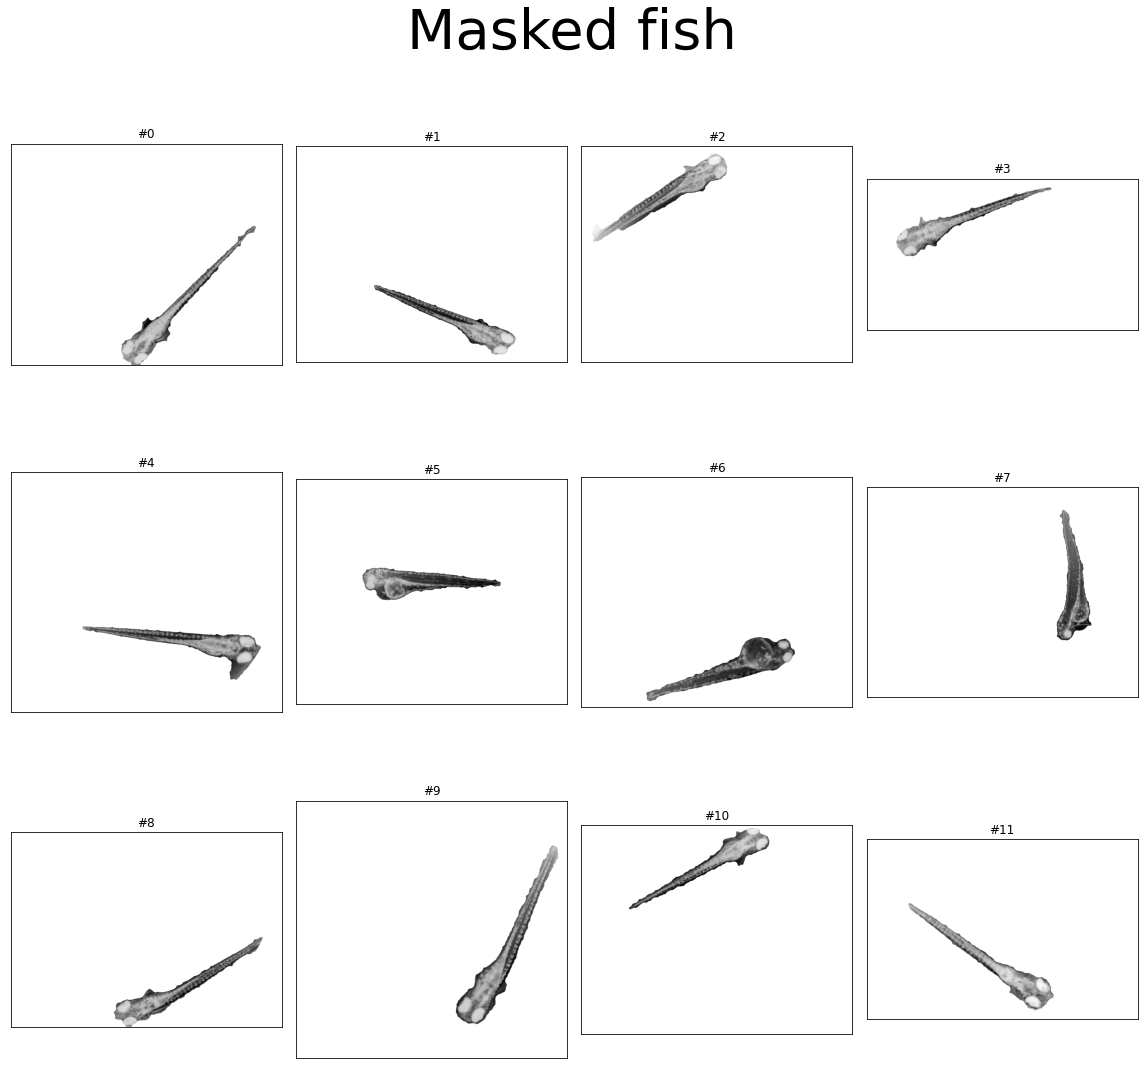

In [4]:
maskeds = list(map(lambda x: (x.fish_props.mask.masked), successful_fishes))
plot_images(maskeds, title="Masked fish")

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11


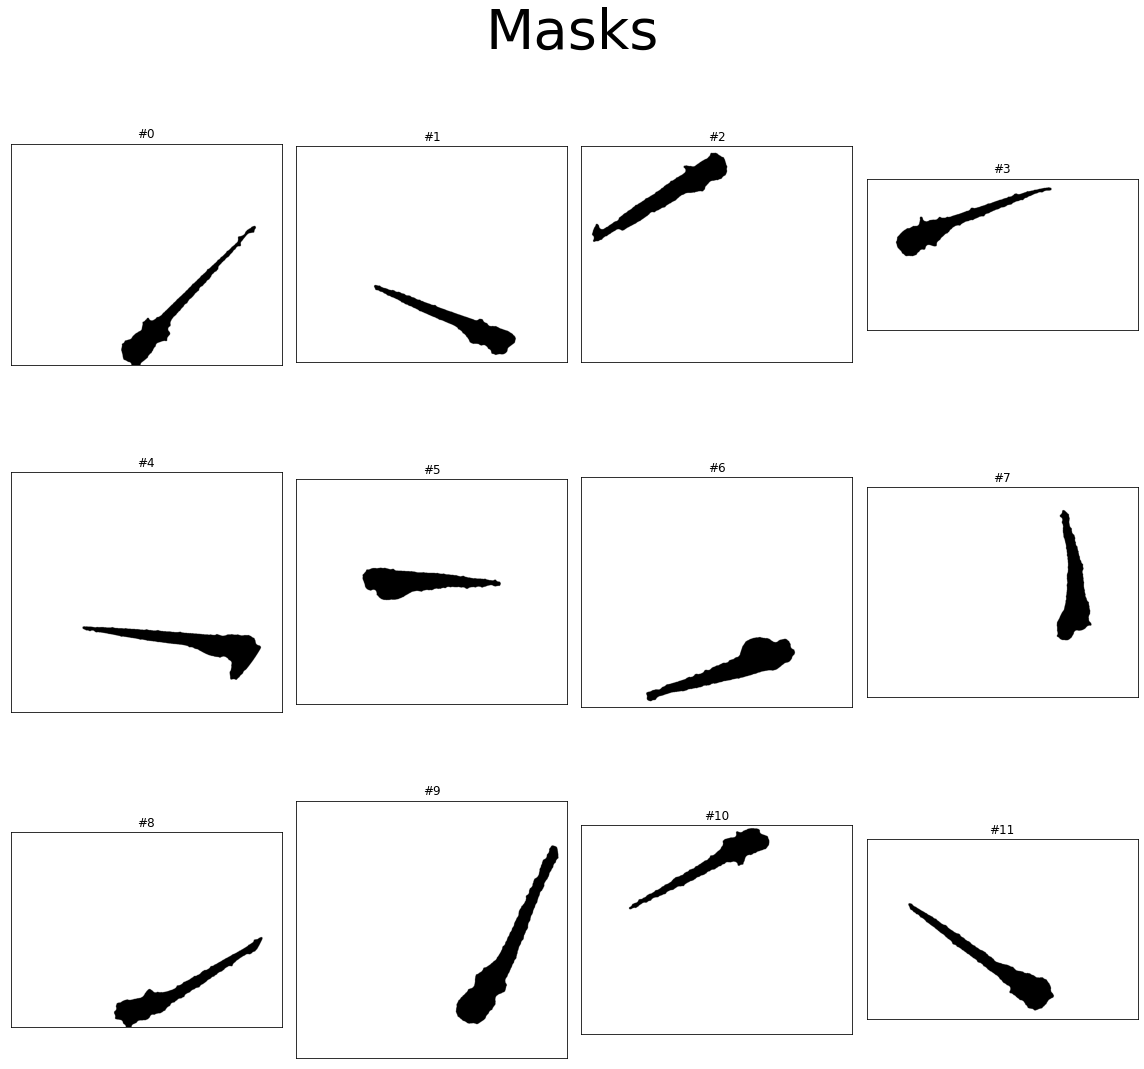

In [5]:
masks = []

for i, fish in enumerate(fishes):
    print(f'#{i}')
    if fish.fish_props.has_fish: masks.append(fish.fish_props.mask.og)
plot_images(masks, nums=True, title="Masks")

#0
has eyes
#1
has eyes
#2
has eyes
#3
has eyes
#4
has eyes
#5
has eyes
#6
has eyes
#7
has eyes
#8
has eyes
#9
has eyes
#10
has eyes
#11
has eyes


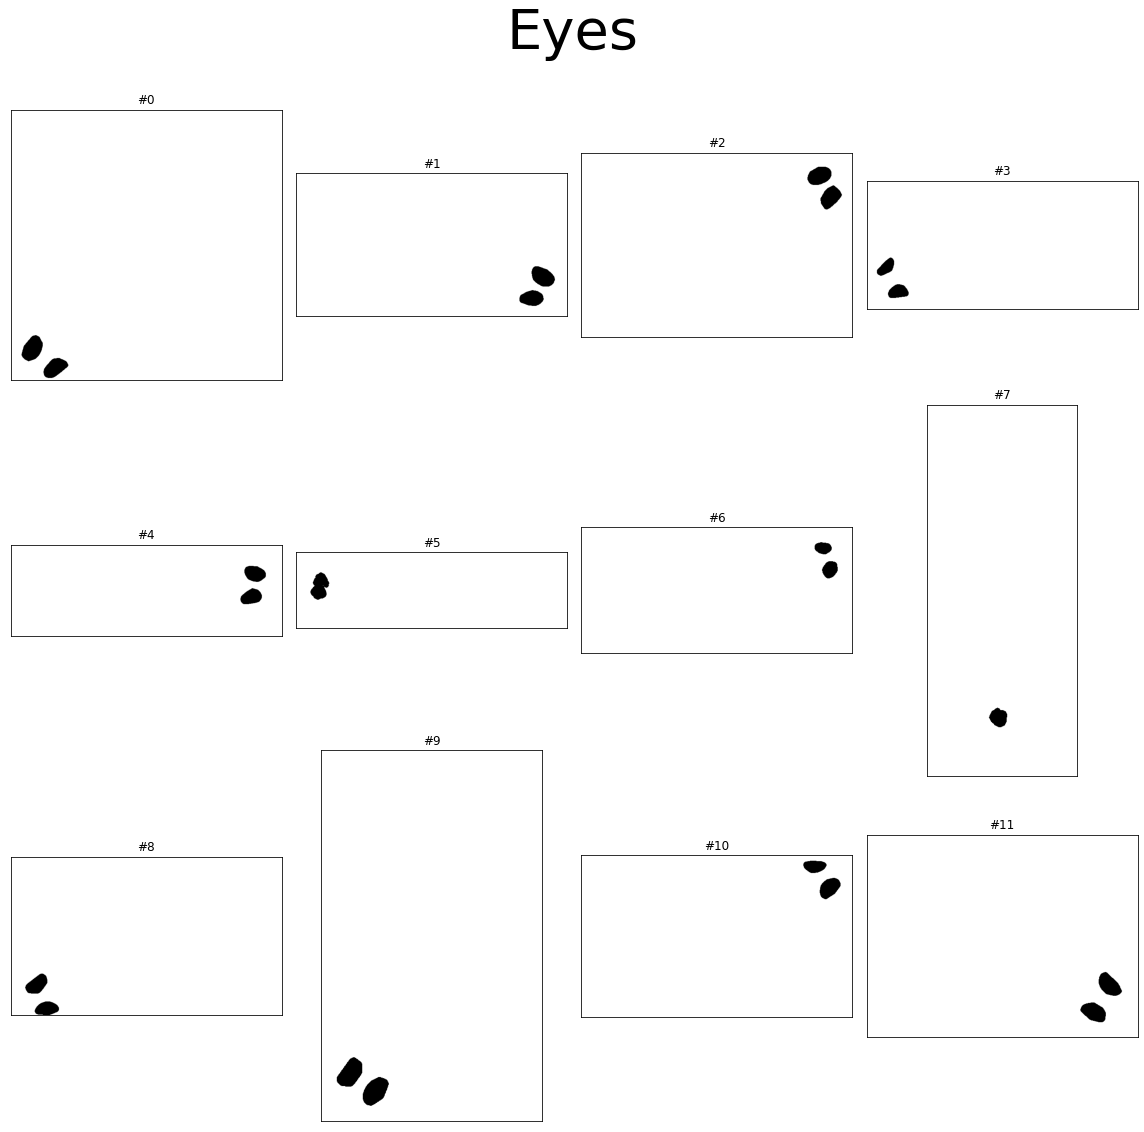

In [6]:
eyes = []

for i, fish in enumerate(successful_fishes):
    print(f'#{i}')
    if fish.fish_props.has_eyes:
        print('has eyes')
        eyes.append(fish.fish_props.eyes)
    else:
        print('has no eyes')

plot_images(eyes, nums=True, title="Eyes")

In [7]:
"""
eyes_on_body = []

for i, fish in enumerate(successful_fishes[::]):
    print(f"#{i}")
    if fish.fish_props.has_eyes:
        eyes_on_body.append((fish.fish_props.mask.cropped.astype(float) + fish.fish_props.eyes.astype(float)))
plot_images(eyes_on_body, nums=True, title="Eyes on Body")
"""

'\neyes_on_body = []\n\nfor i, fish in enumerate(successful_fishes[::]):\n    print(f"#{i}")\n    if fish.fish_props.has_eyes:\n        eyes_on_body.append((fish.fish_props.mask.cropped.astype(float) + fish.fish_props.eyes.astype(float)))\nplot_images(eyes_on_body, nums=True, title="Eyes on Body")\n'

In [8]:
def align_to_x_axis(img: np.ndarray):
    props = regionprops(label(img.astype(bool)))
    angle_in_degrees = props[0].orientation * (180 / np.pi) + 90
    return rotate(img, -angle_in_degrees, resize=True, center=props[0].centroid)


def rotate_back(img: np.ndarray, desired_orientation: float, center=(0, 0)):
    angle_in_degrees = desired_orientation * (180 / np.pi) + 90
    return rotate(img, angle_in_degrees, resize=True, center=center)

# Visualize axes ratio

In [9]:
from skimage.color import gray2rgb
import math


def draw_axes(img: np.ndarray):
    label_img = label(img.astype(bool))
    regions = regionprops(label_img)
    props = regions[0]

    y0, x0 = props.centroid

    bbox = BoundingBox()
    bbox.set(props.bbox)
    x0 = (bbox.y2 - bbox.y1) / 2
    y0 = (bbox.x2 - bbox.x1) / 2

    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length

    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    x3 = x0 + math.sin(orientation) * 0.5 * props.axis_major_length
    y3 = y0 + math.cos(orientation) * 0.5 * props.axis_major_length

    x4 = x0 - math.cos(orientation) * 0.5 * props.axis_minor_length
    y4 = y0 + math.sin(orientation) * 0.5 * props.axis_minor_length

    i = gray2rgb(img)

    cv2.line(i, (int(x1), int(y1)), (int(x4), int(y4)), (255, 0, 0), 3)
    cv2.line(i, (int(x2), int(y2)), (int(x3), int(y3)), (0, 0, 255), 3)

    """    ax.imshow(img, 'gray')
    ax.plot((x0, x1), (y0, y1), '-b', linewidth=2.5)
    ax.plot((x0, x3), (y0, y3), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot((x0, x4), (y0, y4), '-b', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=5)"""

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    #ax.plot(bx, by, '-y', linewidth=2.5)

    return props.axis_major_length / props.axis_minor_length, i

In [12]:
from src.utils import crop_to_bbox

axs = []
for i, mask in enumerate(maskeds):
    ll, b = draw_axes(crop_to_bbox(align_to_x_axis(mask)))
    axs.append(b)

IndexError: list index out of range

In [13]:
indices = [0, 3, 4, 6, 9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 23, 24]
indices = [0, 23, 3, 24, 18, 20, 21, 11, 19, 14, 4, 10, 9, 12, 13, 16]
__6 = []
_6_5 = []
_5_4 = []
_4_1 = []

x = []

for i, index in enumerate(indices):
    ll, b = draw_axes(crop_to_bbox(align_to_x_axis(maskeds[index])))
    if 4 > ll:
        _4_1.append(index)
    elif 6 > ll >= 5:
        _6_5.append(index)
    elif 5 > ll >= 4:
        _5_4.append(index)
    else:
        __6.append(index)
    x.append(b)
    print(f'#{index}')
    print(ll)
plot_images(x, fig=(15, 7))

print(__6)
print(_6_5)
print(_5_4)
print(_4_1)

IndexError: list index out of range

In [14]:
def crop_to_bbox(img):
    props = regionprops(label(img.astype(bool)))[0]
    bbox = BoundingBox()
    bbox.set(props.bbox)
    return bbox.bound_img(img)

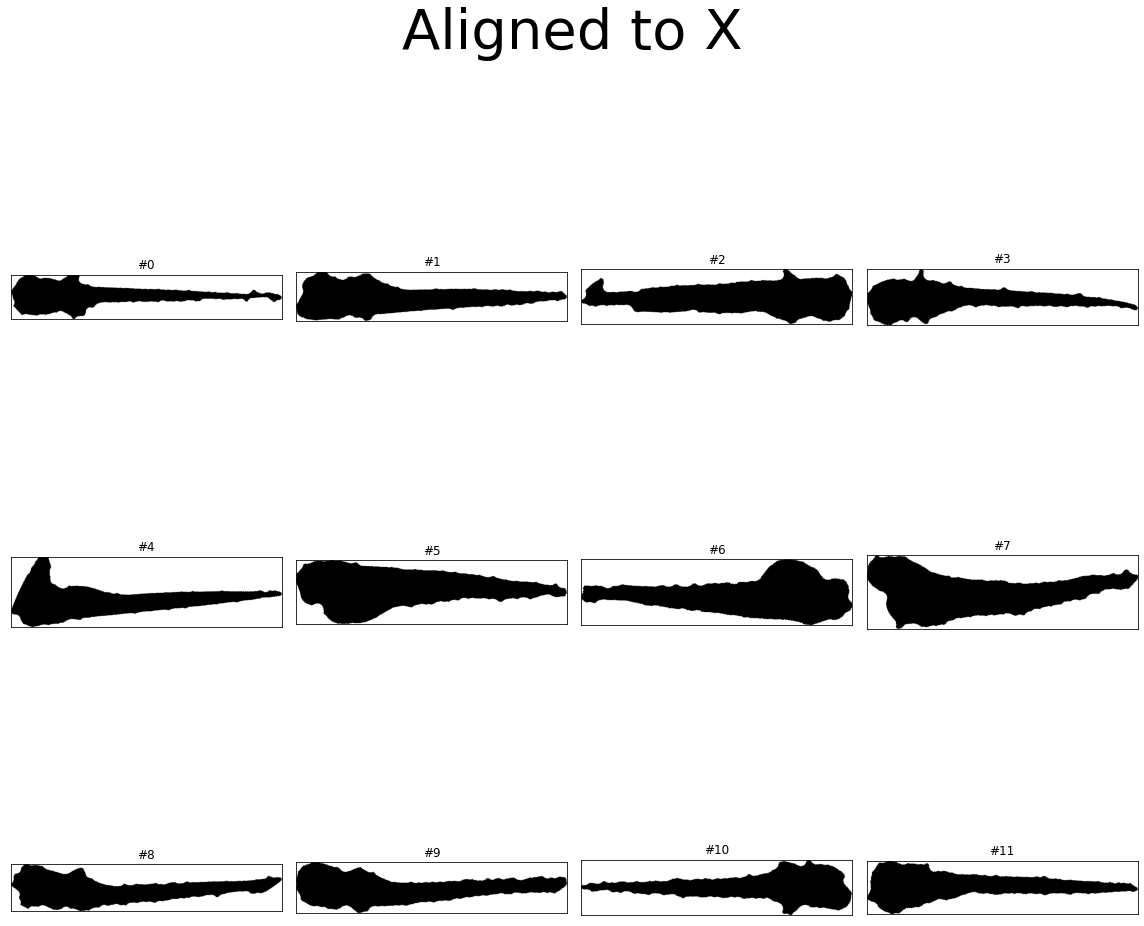

In [15]:
verticals = []

for i, mask in enumerate(masks):
    verticals.append(crop_to_bbox(align_to_x_axis((mask))))

plot_images(verticals, nums=True, title='Aligned to X')